Project description
===

Here we have a small dataset of various data on 500 Megaline clients.  We would like to know if one of the prepaid plans (Surf and Ultimate) brings in more revenue.

First, we should do some data preprocessing: fill in the missing values, clean spelling errors, and change data types. Also, we need to add some new columns that will help in our analysis. After doing so, we could explore our data and test hypotheses.
<br /><br />

**Description of the data**

Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

```
The users table (data on users): 
    user_id — unique user identifier
    first_name — user's name
    last_name — user's last name
    age — user's age (years)
    reg_date — subscription date (dd, mm, yy)
    churn_date — the date the user stopped using the service (if the value is missing, the calling plan was being used when this data was retrieved)
    city — user's city of residence
    plan — calling plan name    

The calls table (data on calls):
    id — unique call identifier
    call_date — call date
    duration — call duration (in minutes)
    user_id — the identifier of the user making the call
    
The messages table (data on texts):
    id — unique text message identifier
    message_date — text message date
    user_id — the identifier of the user sending the text

The internet table (data on web sessions):
    id — unique session identifier
    mb_used — the volume of data spent during the session (in megabytes)
    session_date — web session date
    user_id — user identifier
    
The plans table (data on the plans):
    plan_name — calling plan name
    usd_monthly_fee — monthly charge in US dollars
    minutes_included — monthly minute allowance
    messages_included — monthly text allowance
    mb_per_month_included — data volume allowance (in megabytes)
    usd_per_minute — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)
    usd_per_message — price per text after exceeding the package limits
    usd_per_gb — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)
``` 

## Open the data file and study the general information

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt 
import seaborn as sns
import sidetable
from functools import reduce

In [2]:
try:
    calls = pd.read_csv('megaline_calls.csv')
    data = pd.read_csv('megaline_internet.csv')
    messages = pd.read_csv('megaline_messages.csv')
    plans = pd.read_csv('megaline_plans.csv')
    users = pd.read_csv('megaline_users.csv')
except:
    calls = pd.read_csv('../datasets/megaline_calls.csv') 
    data = pd.read_csv('../datasets/megaline_internet.csv')
    messages = pd.read_csv('../datasets/megaline_messages.csv')
    plans = pd.read_csv('../datasets/megaline_plans.csv')
    users = pd.read_csv('../datasets/megaline_users.csv')

In [3]:
# functions for some drawing on raw data

def show_hist_chart(dataframe: pd.core.frame.DataFrame, column_name: str, table_name: str, bins: int = 10):
    dataframe.plot(
        kind='hist', y=column_name, bins=bins, fontsize=10, legend=None
    )
    beautify_column_name = column_name[0].upper() + column_name[1:].replace('_', ' ')
    beautify_table_name = table_name[0].upper() + table_name[1:].replace('_', ' ')
    plt.title(f'Number of {beautify_table_name} by {beautify_column_name}', fontsize=14)
    plt.xlabel(f'{beautify_column_name}',  fontsize=12)
    plt.show()

In [4]:
display(plans.head())

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


The 'plans' table contains monthly prices, allowance thresholds, and prices after exceeding limits. It doesn't need any cleaning.

In [5]:
users['user_id'] = pd.to_numeric(users['user_id'], downcast='unsigned')
users['age'] = pd.to_numeric(users['age'], downcast='unsigned')
users['plan'] = users['plan'].astype('category')
users.info()
display(users.stb.missing(clip_0=True))
display(users.describe(include='all'))
display(users.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   user_id     500 non-null    uint16  
 1   first_name  500 non-null    object  
 2   last_name   500 non-null    object  
 3   age         500 non-null    uint8   
 4   city        500 non-null    object  
 5   reg_date    500 non-null    object  
 6   plan        500 non-null    category
 7   churn_date  34 non-null     object  
dtypes: category(1), object(5), uint16(1), uint8(1)
memory usage: 21.7+ KB


,missing,total,percent
churn_date,466,500,93.2


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
count,500.000000,500,500,500.000000,500,500,500,34
unique,NaN,458,399,NaN,73,266,2,29
top,NaN,Leonila,David,NaN,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-03-08,surf,2018-12-18
freq,NaN,3,3,NaN,80,5,339,3
mean,1249.500000,NaN,NaN,45.486000,NaN,NaN,NaN,NaN
std,144.481833,NaN,NaN,16.972269,NaN,NaN,NaN,NaN
min,1000.000000,NaN,NaN,18.000000,NaN,NaN,NaN,NaN
25%,1124.750000,NaN,NaN,30.000000,NaN,NaN,NaN,NaN
50%,1249.500000,NaN,NaN,46.000000,NaN,NaN,NaN,NaN
75%,1374.250000,NaN,NaN,61.000000,NaN,NaN,NaN,NaN


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
253,1253,Sumiko,Dudley,28,"Cleveland-Elyria, OH MSA",2018-08-18,ultimate,NaN
341,1341,Kaila,Andrews,28,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-17,surf,NaN
22,1022,Bo,Snow,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-20,surf,2018-09-07
151,1151,Ralph,Monroe,21,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-03-20,surf,NaN
294,1294,Demetrius,Russo,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-19,surf,NaN


The 'users' table has 93.2% of missing values in 'churn_date'.  
Both dates could be converted to datetime.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  uint16 
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float32
dtypes: float32(1), object(2), uint16(1)
memory usage: 2.9+ MB


,id,user_id,call_date,duration
count,137735,137735.000000,137735,137735.000000
unique,137735,NaN,351,NaN
top,1000_93,NaN,2018-12-27,NaN
freq,1,NaN,1091,NaN
mean,NaN,1247.658046,NaN,6.745927
std,NaN,139.416268,NaN,5.839241
min,NaN,1000.000000,NaN,0.000000
25%,NaN,1128.000000,NaN,1.290000
50%,NaN,1247.000000,NaN,5.980000
75%,NaN,1365.000000,NaN,10.690000


,id,user_id,call_date,duration
37687,1141_803,1141,2018-07-13,4.80
74606,1263_590,1263,2018-05-16,0.29
25944,1099_267,1099,2018-07-28,0.00
90437,1328_67,1328,2018-12-10,7.97
72944,1257_684,1257,2018-09-14,0.41


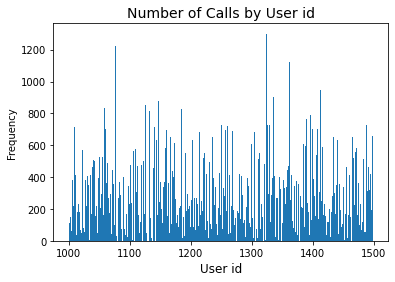

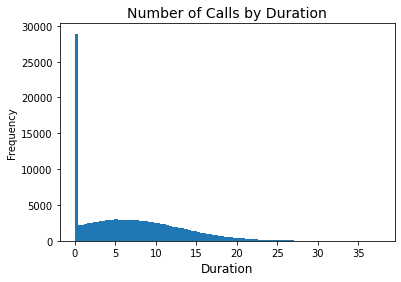

Zero durations: 19.5%


In [6]:
calls['user_id'] = pd.to_numeric(calls['user_id'], downcast='unsigned')
calls['duration'] = pd.to_numeric(calls['duration'], downcast='float')
calls.info()
display(calls.describe(include='all'))
display(calls.sample(5))
show_hist_chart(calls, 'user_id', 'calls', bins=len(calls['user_id'].unique()))
show_hist_chart(calls, 'duration', 'calls', bins=100)
print('Zero durations: {:.1%}'.format(len(calls[calls['duration'] == 0]) / calls.shape[0]))

The 'calls' table doesn't have any missing values but has 19.5% entries with zero duration.  
The 'call_date' could be converted to datetime. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  uint16
 2   message_date  76051 non-null  object
dtypes: object(2), uint16(1)
memory usage: 1.3+ MB


,id,user_id,message_date
28668,1174_458,1174,2018-11-03
1150,1011_113,1011,2018-09-04
28117,1173_228,1173,2018-09-30
2901,1030_0,1030,2018-10-12
7264,1059_136,1059,2018-11-25


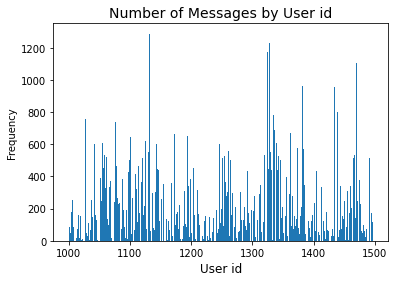

In [7]:
messages['user_id'] = pd.to_numeric(messages['user_id'], downcast='unsigned')
messages.info()
display(messages.sample(5))
show_hist_chart(messages, 'user_id', 'messages', bins=len(messages['user_id'].unique()))

The 'messages' table doesn't have any missing values.  
The 'message_date' could be converted to datetime.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  uint16 
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float32
dtypes: float32(1), object(2), uint16(1)
memory usage: 2.2+ MB


,id,user_id,session_date,mb_used
count,104825,104825.000000,104825,104825.000000
unique,104825,NaN,351,NaN
top,1000_13,NaN,2018-12-24,NaN
freq,1,NaN,851,NaN
mean,NaN,1242.496361,NaN,366.713715
std,NaN,142.053913,NaN,277.170532
min,NaN,1000.000000,NaN,0.000000
25%,NaN,1122.000000,NaN,136.080002
50%,NaN,1236.000000,NaN,343.980011
75%,NaN,1367.000000,NaN,554.609985


,id,user_id,session_date,mb_used
43085,1191_264,1191,2018-12-02,0.000000
4529,1028_82,1028,2018-07-22,0.000000
39967,1181_39,1181,2018-09-08,251.820007
27754,1127_563,1127,2018-08-22,700.890015
76646,1359_333,1359,2018-04-01,404.429993


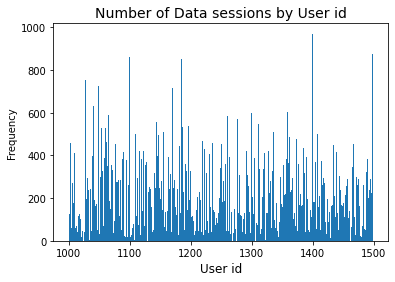

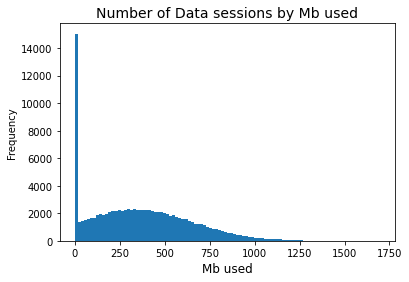

Zero volume: 13.1%


In [8]:
data['user_id'] = pd.to_numeric(data['user_id'], downcast='unsigned')
data['mb_used'] = pd.to_numeric(data['mb_used'], downcast='float')
data.info()
display(data.describe(include='all'))
display(data.sample(5))
show_hist_chart(data, 'user_id', 'data sessions', bins=len(data['user_id'].unique()))
show_hist_chart(data, 'mb_used', 'data sessions', bins=100)
print('Zero volume: {:.1%}'.format(len(data[data['mb_used'] == 0]) / data.shape[0]))

The 'data' table doesn't have any missing values but has 13.1% of sessions with zero traffic volume.  
The 'session_date' could be converted to datetime.

### Conclusion 
The only missing values in our dataset are in the 'users' table, showing those users who are still using our services. This data is irrelevant to our questions, and we could leave it.

Also we should pay attention on zero values in 'calls'.'duration' (19.5%) and 'data'.'mb_used' (13.1%). These missed calls and empty sessions are useless for our current analysis. We could drop them or count them separately.

Dates in 'users', 'calls', 'messages' and 'data' tables should be changed to datatime type.

## Data preprocessing

In [9]:
print('Duplicates in users: {0}, calls: {1}, messages: {2}, data: {2}'.format(users.duplicated().sum(),
calls.duplicated().sum(), messages.duplicated().sum(), data.duplicated().sum()))

Duplicates in users: 0, calls: 0, messages: 0, data: 0


In [10]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d') 
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d') 
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d') 
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d') 
data['session_date'] = pd.to_datetime(data['session_date'], format='%Y-%m-%d') 

In [11]:
# adding columns with month part of the date 

calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
data['month'] = data['session_date'].dt.month

In [12]:
# calls should be rounded up individually, so ceiling their duration before adding 
calls['duration_ceiled'] = np.ceil(calls['duration'])

# calculating monthly calls' durations, number of messages and traffic used for each user
# also summing the number of zero calls and zero data sessions 

monthly_calls = calls[calls['duration'] != 0].pivot_table(index=['user_id','month'], values='duration_ceiled', aggfunc=['count', 'sum'])
monthly_calls.columns = ['calls_number', 'minutes_used']

zero_calls = calls[calls['duration'] == 0].pivot_table(index=['user_id','month'], values='duration_ceiled', aggfunc=['count'])
zero_calls.columns = ['zero_calls_number']

monthly_msg = messages.pivot_table(index=['user_id','month'], values='message_date', aggfunc=['count'])
monthly_msg.columns = ['messages_number']

monthly_data = data[data['mb_used'] != 0].pivot_table(index=['user_id','month'], values='mb_used', aggfunc=['sum'])
monthly_data.columns = ['data_volume']
monthly_data['data_volume_gb'] = monthly_data['data_volume'] / 1024

zero_data = data[data['mb_used'] == 0].pivot_table(index=['user_id','month'], values='mb_used', aggfunc=['count'])
zero_data.columns = ['zero_sessions_number']

dfs = [monthly_calls, zero_calls, monthly_msg, monthly_data, zero_data]
monthly_by_user = reduce(lambda  left,right: pd.merge(left,right,on=['user_id', 'month'], how='outer'), dfs)

display(monthly_by_user.head(5))

calls_number  minutes_used  zero_calls_number  messages_number  \
user_id month                                                                   
1000    12             16.0         124.0                NaN             11.0   
1001    8              22.0         182.0                5.0             30.0   
        9              38.0         315.0               11.0             44.0   
        10             47.0         393.0               18.0             53.0   
        11             49.0         426.0               15.0             36.0   

                data_volume  data_volume_gb  zero_sessions_number  
user_id month                                                      
1000    12      1901.469971        1.856904                   1.0  
1001    8       6919.149902        6.756982                   4.0  
        9      13314.820312       13.002754                  13.0  
        10     22330.490234       21.807119                   8.0  
        11     18504.300781       18.070606                   3.0

In [13]:
print('Number of users in users table:', users.shape[0])
print('Number of users in calls table:', len(calls['user_id'].unique()))
print('Number of users in messages table:', len(messages['user_id'].unique()))
print('Number of users in data table:', len(data['user_id'].unique()))
print('Number of users in combined table:', len(monthly_by_user.index.unique(level=0)))
active = monthly_by_user.index.unique(level=0)
absent_users = users.query('user_id not in @active')
display(absent_users)
print('Checking if users from the user table that are now absent in combined were in calls, messages or data table...')
for u in absent_users['user_id']:
    if len(calls[calls['user_id'] == u]) or len(messages[messages['user_id'] == u]) or len(data[data['user_id'] == u]):
        display(absent_users[absent_users['user_id'] == u])

Number of users in users table: 500
Number of users in calls table: 481
Number of users in messages table: 402
Number of users in data table: 489
Number of users in combined table: 490


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
25,1025,Jess,Wilkinson,64,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-10-28,ultimate,NaT
129,1129,Marin,Bolton,70,"Baton Rouge, LA MSA",2018-11-10,surf,2018-12-27
143,1143,Lorina,Stevens,69,"Cincinnati, OH-KY-IN MSA",2018-10-26,surf,NaT
269,1269,Irving,Thompson,39,"Dallas-Fort Worth-Arlington, TX MSA",2018-09-13,ultimate,2018-12-15
275,1275,Elvie,Velazquez,33,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-11-29,ultimate,NaT
307,1307,Kristopher,Lang,28,"Boston-Cambridge-Newton, MA-NH MSA",2018-12-31,surf,NaT
319,1319,Eliseo,Carson,21,"Colorado Springs, CO MSA",2018-06-17,surf,NaT
378,1378,Mckinley,Clayton,22,"Denver-Aurora-Lakewood, CO MSA",2018-12-17,surf,NaT
463,1463,Dinorah,Simmons,30,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-11-27,ultimate,NaT
473,1473,Kirk,Velez,61,"Louisville/Jefferson County, KY-IN MSA",2018-12-31,surf,NaT


Checking if users from the user table that are now absent in combined were in calls, messages or data table...


Our users express different patterns of behaviour. For example, some don't make calls, and others don't send messages or use any data. Also, 10 users didn't use any of our services this year, and 8 of them still didn't stop their contract.

In [14]:
# merging user city and plan info for ease of future calculations 

monthly_by_user.reset_index(inplace=True)   
monthly_by_user_w_users = pd.merge(monthly_by_user, users[['user_id','city','plan']], on='user_id', )
monthly_by_user_w_plans = pd.merge(monthly_by_user_w_users, plans, left_on='plan', right_on='plan_name')

In [15]:
monthly_by_user_w_plans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                2293 non-null   uint64 
 1   month                  2293 non-null   int64  
 2   calls_number           2256 non-null   float64
 3   minutes_used           2256 non-null   float32
 4   zero_calls_number      2216 non-null   float64
 5   messages_number        1806 non-null   float64
 6   data_volume            2277 non-null   float32
 7   data_volume_gb         2277 non-null   float32
 8   zero_sessions_number   2096 non-null   float64
 9   city                   2293 non-null   object 
 10  plan                   2293 non-null   object 
 11  messages_included      2293 non-null   int64  
 12  mb_per_month_included  2293 non-null   int64  
 13  minutes_included       2293 non-null   int64  
 14  usd_monthly_pay        2293 non-null   int64  
 15  usd_

In [16]:
def revenue(row):
    # monthly revenue from each user 

    extra_minutes = row['minutes_used'] - row['minutes_included'] if (row['minutes_used'] > row['minutes_included']) else 0
    extra_msg = row['messages_number'] - row['messages_included'] if (row['messages_number'] > row['messages_included']) else 0
    extra_data = row['data_volume'] - row['mb_per_month_included'] if (row['data_volume'] > row['mb_per_month_included']) else 0
    
    revenue = row['usd_monthly_pay']
    revenue += extra_minutes * row['usd_per_minute']
    revenue += extra_msg * row['usd_per_message']
    revenue += np.ceil(extra_data / 1024) * row['usd_per_gb']

    return revenue
    
monthly_by_user_w_plans['revenue'] = monthly_by_user_w_plans.apply(revenue,axis=1)
monthly_by_user_w_plans.sample(5)

,user_id,month,calls_number,minutes_used,zero_calls_number,messages_number,data_volume,data_volume_gb,zero_sessions_number,city,plan,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,revenue
2218,1488,12,79.0,721.0,17.0,NaN,19805.730469,19.341534,1.0,"Baton Rouge, LA MSA",surf,50,15360,500,20,10,0.03,0.03,surf,76.63
1245,1167,5,15.0,176.0,3.0,16.0,3367.179932,3.288262,4.0,"Denver-Aurora-Lakewood, CO MSA",surf,50,15360,500,20,10,0.03,0.03,surf,20.00
1296,1178,11,45.0,405.0,12.0,48.0,18044.830078,17.621904,7.0,"Cincinnati, OH-KY-IN MSA",surf,50,15360,500,20,10,0.03,0.03,surf,50.00
1473,1242,10,32.0,255.0,7.0,66.0,10893.719727,10.638398,4.0,"San Antonio-New Braunfels, TX MSA",surf,50,15360,500,20,10,0.03,0.03,surf,20.48
1675,1305,6,59.0,454.0,13.0,1.0,17078.859375,16.678574,11.0,"Los Angeles-Long Beach-Anaheim, CA MSA",surf,50,15360,500,20,10,0.03,0.03,surf,40.00


In [17]:
monthly_by_user_w_plans.sample(5)

,user_id,month,calls_number,minutes_used,zero_calls_number,messages_number,data_volume,data_volume_gb,zero_sessions_number,city,plan,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,revenue
1242,1166,10,23.0,179.0,5.0,NaN,19805.949219,19.341747,11.0,"Baltimore-Columbia-Towson, MD MSA",surf,50,15360,500,20,10,0.03,0.03,surf,70.0
398,1270,10,53.0,512.0,16.0,22.0,18272.970703,17.844698,9.0,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate,70.0
1129,1127,8,27.0,275.0,7.0,9.0,21291.570312,20.792549,4.0,"New York-Newark-Jersey City, NY-NJ-PA MSA",surf,50,15360,500,20,10,0.03,0.03,surf,80.0
229,1155,11,29.0,277.0,5.0,28.0,20099.689453,19.628603,4.0,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate,70.0
652,1459,12,76.0,739.0,18.0,NaN,29330.378906,28.642948,5.0,"San Francisco-Oakland-Berkeley, CA MSA",ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate,70.0


### Conclusion
We don't have any duplicates in this data set, so nothing to drop here.

All dates were converted to datetime.

Here we have missing values in 'users'.'churn_date' that indicate active users. These dates have nothing to do with our questions in hand, so I left it.

However, 'calls' and 'data' have a substantial amount of entries with zero 'duration' and 'mb_used', respectively. Leaving them would affect the means, so I decided to count their number separately.

So I counted monthly calls' durations and quantities, zero calls number, number of messages, traffic volume and amount of zero data sessions for each user. Then, with this aggregated data, I counted the monthly revenue for each user.

## Analyze the data

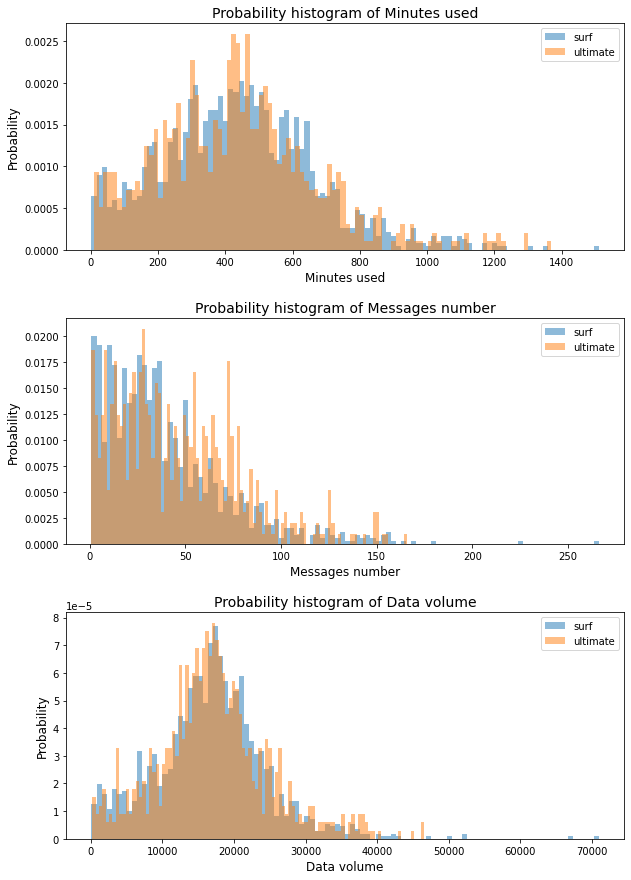

,minutes_used,messages_number,data_volume
count,1544.000000,1222.000000,1558.000000
mean,436.802460,40.109656,16717.703125
std,229.088531,33.035500,7884.683105
min,2.000000,1.000000,92.309998
25%,279.000000,16.000000,12187.955078
50%,430.000000,32.000000,16923.830078
75%,579.000000,54.000000,21039.859375
max,1510.000000,266.000000,70931.593750


Surf plan variances. minutes used: 52481.56, messages number: 1091.34, data volume: 62168224.00



,minutes_used,messages_number,data_volume
count,712.000000,584.000000,719.000000
mean,435.286530,46.296233,17238.642578
std,237.459656,32.942118,7831.018555
min,10.000000,1.000000,233.170013
25%,263.000000,21.000000,12671.130859
50%,425.500000,41.000000,16863.449219
75%,566.000000,66.000000,21025.156250
max,1369.000000,166.000000,46595.328125


Ultimate plan variances. minutes used: 56387.09, messages number: 1085.18, data volume: 61324848.00


In [18]:
def show_comparison_hists(dfs: dict, col_names: list, bins: int=100):
    fig, axes = plt.subplots(len(col_names), 1, figsize=(10, 5*len(col_names)), squeeze=False)
    fig.subplots_adjust(hspace=0.3)
    for i, column in enumerate(col_names):
        beautify_column = column[0].upper() + column[1:].replace('_', ' ')
        for df_name, df in dfs.items():
            axes[i, 0].hist(df[column], bins, alpha=0.5, label=df_name, density=True)
        axes[i, 0].legend(prop={'size': 10})
        axes[i, 0].set_title(f'Probability histogram of {beautify_column}', fontsize=14)
        axes[i, 0].set_xlabel(f'{beautify_column}',  fontsize=12)
        axes[i, 0].set_ylabel(f'Probability',  fontsize=12)
    plt.show()
    
surf = monthly_by_user_w_plans[monthly_by_user_w_plans['plan'] == 'surf']
ultimate = monthly_by_user_w_plans[monthly_by_user_w_plans['plan'] == 'ultimate']

show_comparison_hists({'surf': surf, 'ultimate': ultimate}, 
                      ['minutes_used', 'messages_number', 'data_volume'], bins=100)

display(surf[['minutes_used', 'messages_number', 'data_volume']].describe())
print('Surf plan variances. minutes used: {0:.2f}, messages number: {1:.2f}, data volume: {2:.2f}'.format(
    surf['minutes_used'].var(), surf['messages_number'].var(), surf['data_volume'].var()))
print('')
display(ultimate[['minutes_used', 'messages_number', 'data_volume']].describe())
print('Ultimate plan variances. minutes used: {0:.2f}, messages number: {1:.2f}, data volume: {2:.2f}'.format(
    ultimate['minutes_used'].var(), ultimate['messages_number'].var(), ultimate['data_volume'].var()))

### Conclusion

Here we could see that users of both plans don't differ much in their behaviour. 

The used minutes' distribution for the Surf plan has a mean of 437, a variance of 52482 and a deviation of 229.  
The used minutes' distribution for the Ultimate plan has a mean of 435, a variance of 56388 and a deviation of 238.

The messages distribution for the Surf plan has a mean of 40, a variance of 1091 and a deviation of 33.  
The messages distribution for the Ultimate plan has a mean of 46, a variance of 1085 and a deviation of 33.

The data volume distribution for the Surf plan has a mean of 16.32 Gb, a variance of 62168224 and a deviation of 7.7.  
The data volume distribution for the Ultimate plan has a mean of 16.8 Gb, a variance of 61324848 and a deviation of 7.6.

## Test the hypotheses

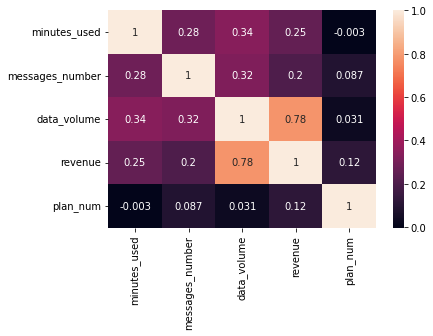

In [19]:
monthly_by_user_w_plans['plan_num'] = monthly_by_user_w_plans['plan'].replace(['surf','ultimate'], [1, 2])
plans_corr = monthly_by_user_w_plans.loc[:,['minutes_used', 'messages_number', 'data_volume', 'revenue', 'plan_num']].corr()
sns.heatmap(plans_corr, annot=True)
plt.show()

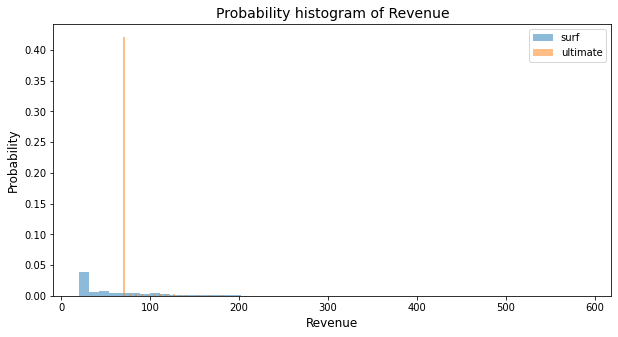

Surf plan average revenue: 60.71
Ultimate plan average revenue: 72.31


In [20]:
show_comparison_hists({'surf': surf, 'ultimate': ultimate}, ['revenue'], bins=50)

print('Surf plan average revenue: {0:.2f}'.format(surf['revenue'].mean()))
print('Ultimate plan average revenue: {0:.2f}'.format(ultimate['revenue'].mean()))

We would like to know if one of our plans brings greater revenue.   
My null hypothesis would be that there is no statistically significant difference between the average revenue from users of Ultimate and Surf calling plans. The alternative hypothesis would be that there is a statistically significant difference. Suggesting that the Ultimate plan brings higher revenue, I choose to perform a one-sided test.  
95% statistical significance level (alpha 0.05) would be enough for our task.

In [21]:
alpha = 0.05
# The small p-value suggests that the populations do not have equal variances.
stat, p  = st.levene(surf['revenue'], ultimate['revenue']) 
equal_var = False if p < 0.05 else True

results = st.ttest_ind(surf['revenue'], ultimate['revenue'], equal_var = equal_var)

# H₀ they are equal
if (results.pvalue / 2 < alpha) and (ultimate['revenue'].mean() > surf['revenue'].mean()):
    print("Reject the null hypothesis that the plans revenue is equal. The Ultimate plan brings more average revenue.")
else:
    print("Can't reject the null hypothesis that the plans revenue is equal.") 

Reject the null hypothesis that the plans revenue is equal. The Ultimate plan brings more average revenue.


### Conclusion 

We don't see any linear correlation between the plan and its revenue. The average revenue from the Surf plan equals 60.7 and from the Ultimate plan 72.3. So I tested the hypothesis that the average revenue from the plans is equal and rejected it. There is a significant difference between average revenues, and the Ultimate plan brings more.

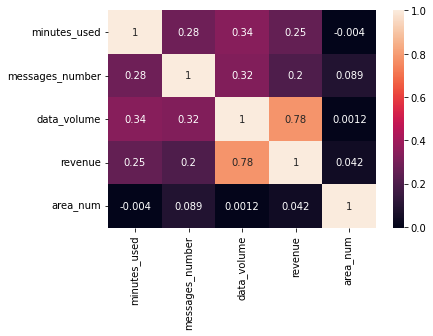

In [22]:
monthly_by_user_w_plans['area_num'] = monthly_by_user_w_plans['city'].apply(lambda x: 1 if x == 'New York-Newark-Jersey City, NY-NJ-PA MSA' else 2)
plans_corr = monthly_by_user_w_plans.loc[:,['minutes_used', 'messages_number', 'data_volume', 'revenue', 'area_num']].corr()
sns.heatmap(plans_corr, annot=True)
plt.show()

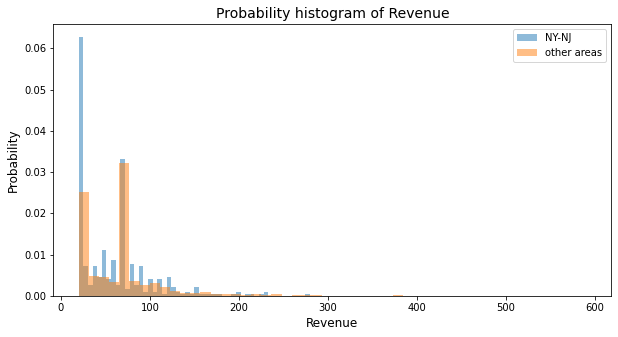

NY-NJ area average revenue: 59.92
Other areas average revenue: 65.22


In [23]:
ny = monthly_by_user_w_plans[monthly_by_user_w_plans['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']
others = monthly_by_user_w_plans[monthly_by_user_w_plans['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']

show_comparison_hists({'NY-NJ': ny, 'other areas': others}, ['revenue'], bins=50)

print('NY-NJ area average revenue: {0:.2f}'.format(ny['revenue'].mean()))
print('Other areas average revenue: {0:.2f}'.format(others['revenue'].mean()))

We would like to know if the average revenue of the users in NY-NJ area is different from that of the users in other regions.   
My null hypothesis would be that their average revenue is equal, and the alternative hypothesis would be that they are not equal.   
95% statistical significance level (alpha 0.05) would be enough for our task.

In [24]:
alpha = 0.05

# The small p-value suggests that the populations do not have equal variances.
stat, p  = st.levene(ny['revenue'], others['revenue']) 
equal_var = False if p < 0.05 else True
results = st.ttest_ind(ny['revenue'], others['revenue'], equal_var = equal_var)

# H₀ the average revenue is equal
if results.pvalue < alpha:
    print("Reject the null hypothesis that they are equal.") # They are different
else:
    print("Can't reject the null hypothesis that they are equal.") # Can't reject they are equal

Reject the null hypothesis that they are equal.


### Conclusion 

Comparing data from users in the NY-NJ area and other places, we don't see any linear correlation between the region and its revenue. The average revenue of the NY-NJ area equals 59.9 and of users in other regions 65.2. So I tested the hypothesis that the average revenues are equal and rejected it. The average revenue of the users in NY-NJ area is different from that of the users in other regions.

## Overall conclusion

Here we have a small dataset on our users. After light preprocessing that consisted of changing datatypes and adding extra columns, I aggregated monthly usages of call minutes, messages, and data for each user. These sums let me calculate the users' monthly revenue.

The distributions of used minutes, messages and data volumes don't differ much between users of different plans. Thus, both groups of customers behave similarly.

I tested if the average revenues from the Ultimate and Surf plans are equal. The test showed a significant difference between average revenues, and the **Ultimate** plan brings in *more revenue*.

Also, I compared the data from users in the NY-NJ area and all other places combined. The test showed a significant difference between average revenues in these areas.